# Reinforcement Learning Solution to the Towers of Hanoi Puzzle

*Sean Russell*

In [34]:
import copy
import random
import numpy as np
import matplotlib.pyplot as plt

def printState(state):
    print ('-',*list(reversed(state[0])))
    print ('-',*list(reversed(state[1])))
    print ('-',*list(reversed(state[2])))

def validMoves(state):
    moves = []
    for x in range(3):
        for y in range(3):
            if x == y or not state[x]:
                continue
            elif not state[y] or state[x][0] < state[y][0]:
                moves.append([x+1,y+1])
    return moves

def makeMove(state,move):
    newState = copy.deepcopy(state)
    newState[move[1]-1].insert(0,newState[move[0]-1][0])
    newState[move[0]-1] = newState[move[0]-1][1:]
    return newState

def key(state, move):
    return tuple(tuple(s) for s in state), tuple(move)

def epsilonGreedy(state, epsilon, validActionsF, Q):
    validMoves = validActionsF(state)
    if np.random.uniform() < epsilon:
        return random.choice(validMoves)
    else:
        Qs = []
        for m in validMoves:
            if key(state,m) not in Q:
                Q[key(state,m)] = 1
            Qs.append(Q[key(state,m)])
        return validMoves[ np.argmax(Qs) ]

def trainQ(nRepetitions, learningRate, epsilonDecayFactor, validMovesF, makeMoveF):
    goalState = [[],[],[1,2,3]]
    startState = [[1,2,3],[],[]]
    steps = []
    epsilon = 1.0
    Q = {}
    
    for i in range(nRepetitions):
        epsilon *= epsilonDecayFactor
        state = startState
        action = epsilonGreedy(state, epsilon, validMovesF, Q)
        numberOfSteps = 0
        while True:
            numberOfSteps += 1
            if makeMoveF(state,action) == goalState:
                Q[key(state,action)] = -1
                break
            else:
                nextState = makeMoveF(state,action)
                nextAction = epsilonGreedy(nextState, epsilon, validMovesF, Q)
                if key(nextState,nextAction) not in Q:
                    Q[key(nextState,nextAction)] = -1
                if key(state,action) not in Q:
                    Q[key(state,action)] = -1
                Q[key(state,action)] += learningRate * (-1 + Q[key(nextState,nextAction)] - Q[key(state,action)])
                state, action = nextState, nextAction
        steps.append(numberOfSteps)
    return Q, steps


def testQ(Q, maxSteps, validMovesF, makeMoveF):
    state = [[1,2,3],[],[]]
    goal = [[],[],[1,2,3]]
    steps = 0
    path = [copy.deepcopy(state)]
    while state != goal:
        steps += 1
        bestMove = validMovesF(state)[0]
        for m in validMovesF(state):
            if Q[key(state,m)] > Q[key(state,bestMove)]:
                bestMove = m
        state = makeMoveF(state,bestMove)
        path.append(copy.deepcopy(state))
        if steps >= maxSteps:
            break
    return path

The way reinforcement learning works here is by generating the dictionary Q. Q takes as a key the current state and an action, and the values it holds are the expected payoffs for each of those state/action pairs. In this case, that literally means the number of steps required in order to solve the towers of hanoi problem.

So having this Q dictionary makes decisions easy. Just choose the action with the best Q value at every step along the way to solving whatever problem you gotta solve. The tricky part is generating the Q table.

To generate such a table, you just play a bunch of games. Whenever you hit a goal state, the state and action pair that lead to that goal get the best possible Q values. And whenever you make a move, update the Q value for that move and its state based on the expected result of the next move. However, one more important piece is needed. In order for reinforcement learning to work, the algorithm has to be free to search unexplored, potentially non-optimal paths. To do this, an epsilon value that decreases with each game determines whether the algorithm takes the optimal move at every step, or goes off and explores somewhere random.

trainQ is used to create this Q dictionary. nRepetitions counts the number of games that the algorithm should play before its decided it has learned enough. More difficult problems therefore will probably require more repetitons. learningRate is the speed with which Q values are updated based upon exploration. A high learning rate means that the algorithm will quickly find decent Q values, but it might be a bit to spastic to settle into the optimal Q values. epsilonDecayFactor determines the rate at which the epsilon value decays, a higher decay factor means there will be less exploration.

testQ takes the Q dictionary that was created from trainQ and uses it to solve the Towers of Hanoi by repeatedly choosing the action with the best Q value until the solution is discovered.

# Examples

In [2]:
validMoves([[1,2,3],[],[]])

[[1, 2], [1, 3]]

In [3]:
state = [[1,2],[3],[]]
move = validMoves(state)[0]
newstate = makeMove(state, move)
newstate

[[2], [1, 3], []]

In [4]:
printState(newstate)

[2]
[1, 3]
[]


Printing is not particularly elegant, the state is shown rotated by 90 degrees. But its super simple!

In [5]:
Q, stepsToGoal = trainQ(50, 0.5, 0.7, validMoves, makeMove)

In [6]:
Q

{(((), (1,), (2, 3)), (2, 1)): -1.4765625,
 (((), (1,), (2, 3)), (2, 3)): -1,
 (((), (1,), (2, 3)), (3, 1)): -1.0625,
 (((), (1, 2), (3,)), (2, 1)): -3.0000000000271143,
 (((), (1, 2), (3,)), (2, 3)): -3.30029296875,
 (((), (1, 2), (3,)), (3, 1)): -3.64599609375,
 (((), (1, 2, 3), ()), (2, 1)): -4.81103515625,
 (((), (1, 2, 3), ()), (2, 3)): -4.91607666015625,
 (((), (1, 3), (2,)), (2, 1)): -4.767486572265625,
 (((), (1, 3), (2,)), (2, 3)): -4.965423583984375,
 (((), (1, 3), (2,)), (3, 1)): -4.8505706787109375,
 (((), (2,), (1, 3)), (2, 1)): -2.958984375,
 (((), (2,), (1, 3)), (3, 1)): -2.71429443359375,
 (((), (2,), (1, 3)), (3, 2)): -3.028076171875,
 (((), (2, 3), (1,)), (2, 1)): -4.63360595703125,
 (((), (2, 3), (1,)), (3, 1)): -4.5516357421875,
 (((), (2, 3), (1,)), (3, 2)): -4.6199951171875,
 (((), (3,), (1, 2)), (2, 1)): -5.259757995605469,
 (((), (3,), (1, 2)), (3, 1)): -4.96820068359375,
 (((), (3,), (1, 2)), (3, 2)): -5.155059814453125,
 (((1,), (), (2, 3)), (1, 2)): -1.617187

As expected, the Q values for states and actions that lead to a solution have a Q value of -1, and those that are close to solutions are greater than those that are far away. Also, I'm pretty sure that the solution can be reached from any state within 7 moves, so no Q value should be substantially less than -7, which is also true.

In [7]:
stepsToGoal

[84,
 71,
 111,
 33,
 33,
 39,
 14,
 58,
 13,
 59,
 58,
 12,
 14,
 27,
 9,
 18,
 21,
 13,
 12,
 42,
 12,
 7,
 7,
 9,
 8,
 7,
 11,
 7,
 10,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7]

As the computer learns how to solve the Towers of Hanoi, the number of steps required to find a solution goes down.

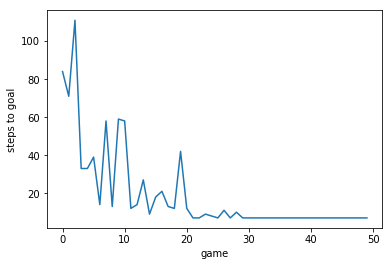

In [24]:
%matplotlib inline

plt.xlabel('game')
plt.ylabel('steps to goal')
plt.plot(stepsToGoal);

In a more visual form, the number of steps required to reach the goal decreases as the number of games increases.

In [25]:
path = testQ(Q, 20, validMoves, makeMove)

testQ returns a solution to the Towers of Hanoi puzzle as a sequence of states

In [26]:
path

[[[1, 2, 3], [], []],
 [[2, 3], [], [1]],
 [[3], [2], [1]],
 [[3], [1, 2], []],
 [[], [1, 2], [3]],
 [[1], [2], [3]],
 [[1], [], [2, 3]],
 [[], [], [1, 2, 3]]]

In [35]:
for s in path:
    printState(s)
    print()

- 3 2 1
-
-

- 3 2
-
- 1

- 3
- 2
- 1

- 3
- 2 1
-

-
- 2 1
- 3

- 1
- 2
- 3

- 1
-
- 3 2

-
-
- 3 2 1



Printed nicely you can see it giving the optimal solution.

In [36]:
%run -i A5grader.py


Testing validMoves([[1], [2], [3]])

--- 10/10 points. Correctly returned [[1, 2], [1, 3], [2, 3]]

Testing validMoves([[], [], [1, 2, 3]])

--- 10/10 points. Correctly returned [[3, 1], [3, 2]]

Testing makeMove([[], [], [1, 2, 3]], [3, 2])

--- 10/10 points. Correctly returned [[], [1], [2, 3]]

Testing makeMove([[2], [3], [1]], [1, 2])

--- 10/10 points. Correctly returned [[], [2, 3], [1]]

Testing   Q, steps = trainQ(1000, 0.5, 0.7, validMoves, makeMove).

--- 10/10 points. Q dictionary has correct number of entries.

--- 10/10 points. The mean of the number of steps is 7.666 which is correct.

Testing   path = testQ(Q, 20, validMoves, makeMove).

--- 20/20 points. Correctly returns path of length 8, less than 10.

A5 Execution Grade is 80/80

 Remaining 20 points will be based on your text describing the trainQ and test! functions.

A5 FINAL GRADE is __/100
